In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# potentielt set antallet af downsampling lag up, da vi skal have et featuremap på en skala så man kan se blodårer ? (selvom det gør billedet større egentlig?:)

#Har tilføjet batchnormalisation... 


class EncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn_enc0 = nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(2, 2)  # 500 -> 250               128 -> 64
        
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_enc1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)  # 250 -> 125                         64 -> 32
        
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_enc2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # 125 -> 62 ???                                 32 -> 16
       
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_enc3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)  # 61 -> 31                                 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(62)  # 31 ->62                     8 -> 16
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec0 = nn.BatchNorm2d(64)
        
        self.upsample1 = nn.Upsample(125)  #  62 -> 125                          16 -> 32
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec1 = nn.BatchNorm2d(64)
        
        self.upsample2 = nn.Upsample(250)  #125 -> 250                  32 -> 64
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec2 = nn.BatchNorm2d(64)
        
        self.upsample3 = nn.Upsample(500)  # 250 -> 500                       64 -> 128
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)
        

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bn_enc0(self.enc_conv0(x))))
        e1 = self.pool1(F.relu(self.bn_enc1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bn_enc2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bn_enc3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.bn_dec0(self.dec_conv0(self.upsample0(b))))
        d1 = F.relu(self.bn_dec1(self.dec_conv1(self.upsample1(d0))))
        d2 = F.relu(self.bn_dec2(self.dec_conv2(self.upsample2(d1))))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from time import time  # Correct import

def train(model, opt, loss_fn, epochs, train_loader, val_loader):
    # Grab a batch of validation data
    X_test, Y_test = next(iter(val_loader))

    for epoch in range(epochs):
        
        print('* Epoch %d/%d' % (epoch + 1, epochs))

        avg_loss = 0
        model.train()  # Set model to training mode

        for X_batch, Y_batch in train_loader:
            # Move data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # Zero the gradients
            opt.zero_grad()

            # Forward pass
            Y_pred = model(X_batch)
            print("Y_pred shape:", Y_pred.shape)
            print("Y_batch shape:", Y_batch.shape)

            # Calculate loss
            loss = loss_fn(Y_pred, Y_batch)  # Correct order: model output first
            loss.backward()  # Backward pass
            opt.step()  # Update weights

            # Accumulate average loss
            avg_loss += loss.item() / len(train_loader)

        toc = time()  # End timing
        print(' - loss: %f' % avg_loss)

        # Evaluate on the validation set
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation for evaluation
            Y_hat = F.sigmoid(model(X_test.to(device))).detach().cpu()

        # Clear previous output and plot the results
        clear_output(wait=True)  # Only if using Jupyter Notebook
        for k in range(4):  # Display first 4 images
            plt.subplot(2, 6, k + 1)
            plt.imshow(np.rollaxis(X_test[k].cpu().numpy(), 0, 3), cmap='gray')  # Move X_test to CPU
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k + 7)
            plt.imshow(Y_hat[k, 0].cpu().numpy(), cmap='gray')  # Move Y_hat to CPU
            plt.title('Output')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch + 1, epochs, avg_loss))
        plt.show()


In [10]:
import 
from Performance_Metrics import dice_coefficient, intersection_over_union, accuracy, sensitivity, specificity
import time  # Add this import at the top of your code

def test(model, test_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():  # Disable gradient calculation
        for X_test_batch, Y_test_batch in test_loader:
            X_test_batch = X_test_batch.to(device)
            Y_test_batch = Y_test_batch.to(device)

            Y_test_pred = model(X_test_batch)
            loss = loss_fn(Y_test_pred, Y_test_batch)  # Compute test loss
            test_loss += loss.item()  # Accumulate test loss

            all_y_true.append(Y_test_batch.cpu())
            all_y_pred.append(Y_test_pred.cpu())

    avg_test_loss = test_loss / len(test_loader)
    print('Test Loss: %f' % avg_test_loss)

    # Concatenate all predictions and ground truths
    all_y_true = torch.cat(all_y_true)
    all_y_pred = torch.cat(all_y_pred)

    # Calculate metrics
    dice = dice_coefficient(all_y_true, all_y_pred)
    iou = intersection_over_union(all_y_true, all_y_pred)
    acc = accuracy(all_y_true, all_y_pred)
    sens = sensitivity(all_y_true, all_y_pred)
    spec = specificity(all_y_true, all_y_pred)

    # Print metrics
    print(f'Dice: {dice:.4f}, IoU: {iou:.4f}, Accuracy: {acc:.4f}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}')

    # Pause for a moment to allow user to read metrics
    time.sleep(5)  # Adjust time as needed, here it waits for 5 seconds

    # Visualization of results
    clear_output(wait=True)  # Clear previous output
    X_test_batch, Y_test_batch = next(iter(test_loader))
    Y_test_pred = F.sigmoid(model(X_test_batch.to(device))).detach().cpu()

    # Plot the first 4 images and their predictions
    for k in range(4):  # For example, visualize the first 4 elements
        plt.subplot(2, 6, k + 1)
        plt.imshow(np.rollaxis(X_test_batch[k].cpu().numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k + 7)
        plt.imshow(Y_test_pred[k, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')

    plt.suptitle('Test - Loss: %f' % avg_test_loss)
    plt.show()  # This will block execution until you close the plot


ModuleNotFoundError: No module named 'Performance_Metrics'

In [200]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [201]:
model = EncDec().to(device)
summary(model, (3, 500, 500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 500, 500]           1,792
       BatchNorm2d-2         [-1, 64, 500, 500]             128
         MaxPool2d-3         [-1, 64, 250, 250]               0
            Conv2d-4         [-1, 64, 250, 250]          36,928
       BatchNorm2d-5         [-1, 64, 250, 250]             128
         MaxPool2d-6         [-1, 64, 125, 125]               0
            Conv2d-7         [-1, 64, 125, 125]          36,928
       BatchNorm2d-8         [-1, 64, 125, 125]             128
         MaxPool2d-9           [-1, 64, 62, 62]               0
           Conv2d-10           [-1, 64, 62, 62]          36,928
      BatchNorm2d-11           [-1, 64, 62, 62]             128
        MaxPool2d-12           [-1, 64, 31, 31]               0
           Conv2d-13           [-1, 64, 31, 31]          36,928
         Upsample-14           [-1, 64,

In [11]:
#import dataset DRIVE 
from DRIVE_dataloader import train_loader, val_loader, test_loader

ModuleNotFoundError: No module named 'DRIVE_dataloader'

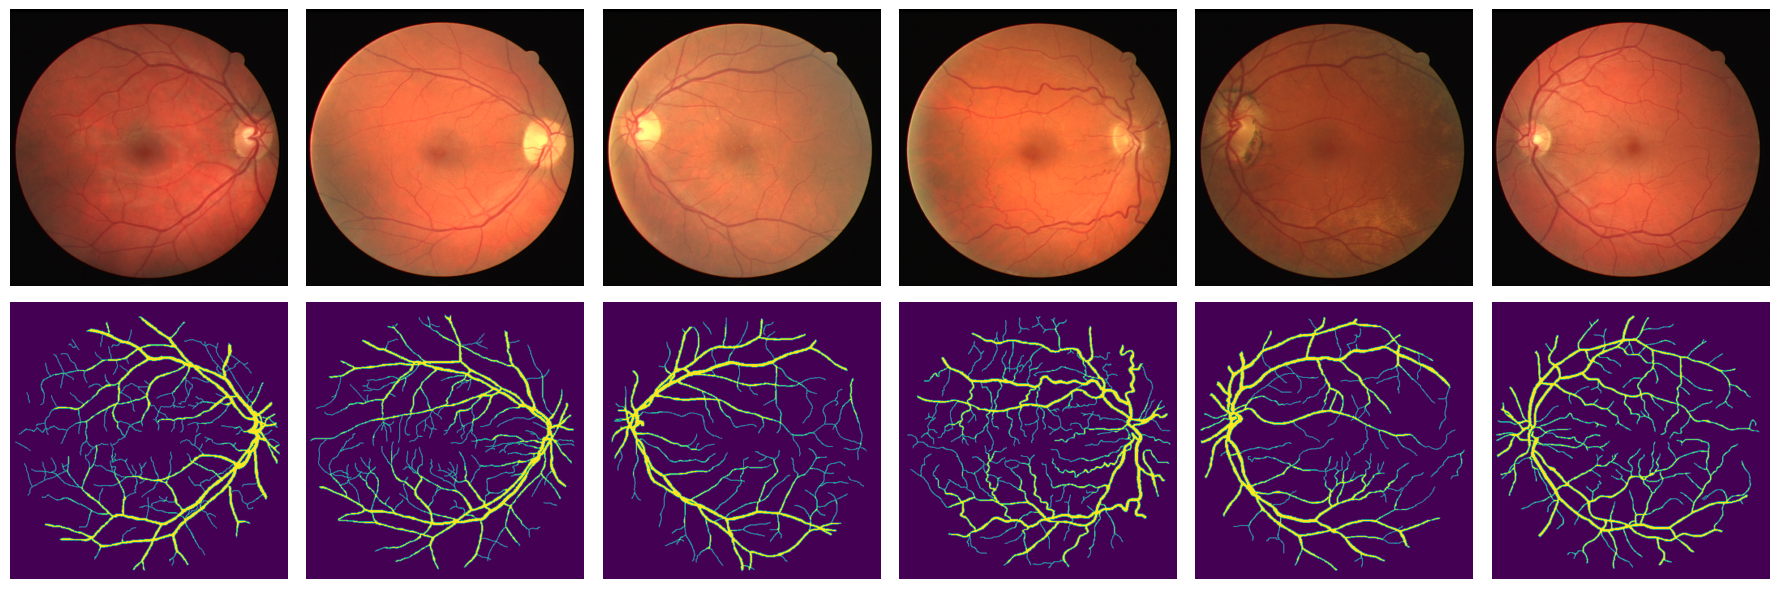

In [203]:
#PLotting images and masks to see everything looks fine 
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))
    plt.axis('off')  


    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
    plt.axis('off')  
    plt.tight_layout()

plt.show()

In [204]:
#image shape = torch.Size([12, 3, 500, 500]) for train
# image shape = torch.Size([4, 3, 500, 500]) for validation 
# image shape = torch.Size([4, 3, 500, 500]) for testing 
print(images.shape)
print(labels.shape)


torch.Size([12, 3, 500, 500])
torch.Size([12, 1, 500, 500])


In [205]:
from UNet2 import bce_loss, dice_loss, focal_loss, bce_total_variation

train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, val_loader)

TypeError: 'module' object is not callable

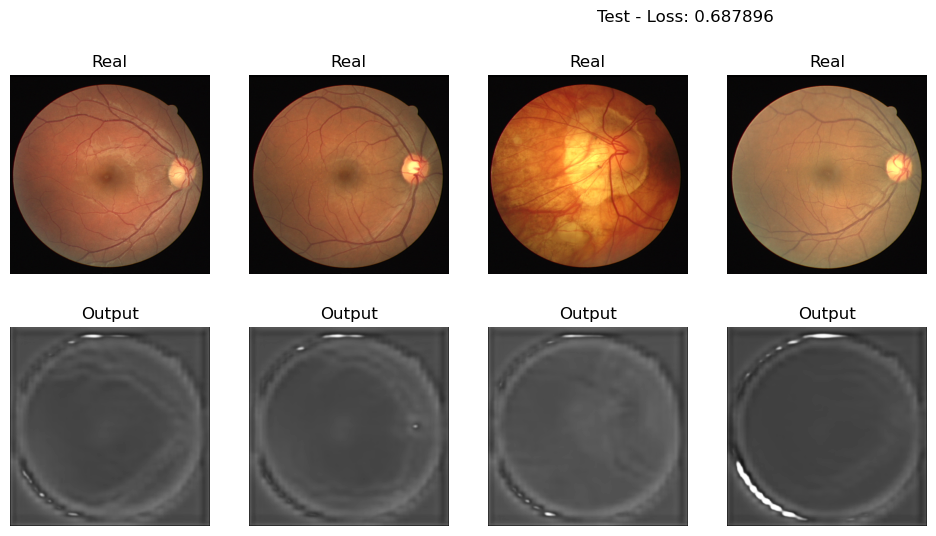

In [192]:

test(model, test_loader, bce_loss) 